In [2]:
import pandas as pd
import tensorflow as tf
from keras.layers import Dense,TimeDistributed,LSTM,Dropout,Bidirectional,RNN,SimpleRNN
from keras.activations import sigmoid,relu
from keras import Sequential
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv(r"C:\Users\visha\OneDrive\Documents\Dataset\current_time_series\train.csv")

In [4]:
df.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500


In [6]:
df.isnull().sum()

row_id         0
datetime       0
energy      1900
dtype: int64

In [7]:
df.describe()

,row_id,energy
count,94992.000000,93092.000000
mean,47496.500000,1702.995014
std,27421.972723,369.322103
min,1.000000,866.388600
25%,23748.750000,1431.541100
50%,47496.500000,1654.465800
75%,71244.250000,1935.993450
max,94992.000000,3374.399600


In [8]:
df.drop(["row_id"],axis =1,inplace=True)

<AxesSubplot:xlabel='datetime'>

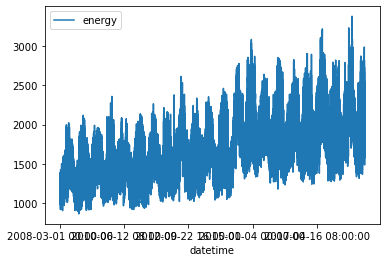

In [9]:
df.plot(x="datetime",y = "energy")

In [10]:
#df.reset_index(inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['Time'] = df['datetime'].dt.time

In [11]:
df.fillna(method ="ffill",inplace=True)

In [12]:
df_hrs = df['Time'].astype(str).str.split(':', expand=True).astype(float)
#

In [13]:
df["hours"] = df_hrs[0]

In [14]:
df.head()

,datetime,energy,day,month,year,Time,hours
0,2008-03-01 00:00:00,1259.985563,1,3,2008,00:00:00,0.0
1,2008-03-01 01:00:00,1095.541500,1,3,2008,01:00:00,1.0
2,2008-03-01 02:00:00,1056.247500,1,3,2008,02:00:00,2.0
3,2008-03-01 03:00:00,1034.742000,1,3,2008,03:00:00,3.0
4,2008-03-01 04:00:00,1026.334500,1,3,2008,04:00:00,4.0


In [15]:
df.drop(["datetime"],axis=1,inplace=True)
df.drop(['Time'],axis=1,inplace=True)

In [17]:
output_scaler = MinMaxScaler()
df['energy']=output_scaler.fit_transform(df['energy'].values.reshape(-1,1))

In [18]:
output = df["energy"]
df_train_new = df.drop(["energy"],axis=1)

In [19]:
scaler =MinMaxScaler()
scaler.fit(df_train_new)
df_train_new =scaler.transform(df_train_new)

In [20]:
from sklearn.model_selection import train_test_split
train_x,val_x,train_y,val_y = train_test_split(df_train_new,output,test_size=0.01)

# Model 1- RNN

In [22]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(20,activation="relu",return_sequences=True, input_shape=(train_x.shape[1],1)))
rnn_model.add(Dropout(0.1))

rnn_model.add(SimpleRNN(10,activation="relu",return_sequences=True))
rnn_model.add(Dropout(0.1))

rnn_model.add(SimpleRNN(20,activation="relu",return_sequences=False))
rnn_model.add(Dropout(0.1))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 4, 20)             440       
                                                                 
 dropout (Dropout)           (None, 4, 20)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 4, 10)             310       
                                                                 
 dropout_1 (Dropout)         (None, 4, 10)             0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20)                620       
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 2

In [23]:
rnn_model.compile(optimizer="adam",loss="MSE")
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
rnn_model.fit(train_x, train_y,validation_data=(val_x,val_y), epochs=20, batch_size=32,callbacks=[callback])

Epoch 1/20
2939/2939 [==============================] - 20s 6ms/step - loss: 0.0115 - val_loss: 0.0082
Epoch 2/20
2939/2939 [==============================] - 17s 6ms/step - loss: 0.0076 - val_loss: 0.0061
Epoch 3/20
2939/2939 [==============================] - 16s 5ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 4/20
2939/2939 [==============================] - 15s 5ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 5/20
2939/2939 [==============================] - 14s 5ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 6/20
2939/2939 [==============================] - 14s 5ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 7/20
2939/2939 [==============================] - 11s 4ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 8/20
2939/2939 [==============================] - 12s 4ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 9/20
2939/2939 [==============================] - 14s 5ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 10/20
2939/2939 [==============================] - 12s 4ms/step - l

# Model 2 - LSTM(Bi - directional)

In [ ]:
model = Sequential()
model.add(LSTM(units =128, activation='relu', return_sequences=True, input_shape = (train_x.shape[1],1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units =56, activation='tanh', return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next value

# Model 2 - LSTM

In [26]:
model = Sequential()
model.add(LSTM(200, input_shape = (train_x.shape[1],1), activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])

In [27]:
model.compile(optimizer="adam",loss="MSE")
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(train_x, train_y,validation_data=(val_x,val_y), epochs=20, batch_size=32,callbacks=[callback])

Epoch 1/20
2939/2939 [==============================] - 17s 5ms/step - loss: 0.0105 - val_loss: 0.0068
Epoch 2/20
2939/2939 [==============================] - 17s 6ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 3/20
2939/2939 [==============================] - 16s 5ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 4/20
2939/2939 [==============================] - 16s 6ms/step - loss: 0.0049 - val_loss: 0.0055
Epoch 5/20
2939/2939 [==============================] - 16s 5ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 6/20
2939/2939 [==============================] - 16s 5ms/step - loss: 0.0046 - val_loss: 0.0049
Epoch 7/20
2939/2939 [==============================] - 17s 6ms/step - loss: 0.0045 - val_loss: 0.0050
Epoch 8/20
2939/2939 [==============================] - 17s 6ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 9/20
2939/2939 [==============================] - 16s 5ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 10/20
2939/2939 [==============================] - 17s 6ms/step - l

# # Model 2 - LSTM(Multi - Bi - directional) 

In [ ]:
model = Sequential()
model.add(LSTM(units =128, activation='relu', return_sequences=True, input_shape = (train_x.shape[1],1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units =256, activation='relu', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units =128, activation='relu', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units =256, activation='relu', return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next value

In [ ]:
model.compile(optimizer='adam',loss="mean_squared_error")#,metrics=["accuracy"])
model.summary()

In [ ]:
#import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(train_x,train_y,batch_size=16,validation_data=(val_x,val_y),epochs=30,callbacks=[callback])

In [28]:
df_test = pd.read_csv(r"C:\Users\visha\OneDrive\Documents\Dataset\current_time_series\Test.csv")
df_test_new = df_test.drop('row_id',axis=1)
df_test_new['datetime'] = pd.to_datetime(df_test_new['datetime'])
df_test_new['day'] = pd.to_datetime(df_test_new['datetime']).dt.day
df_test_new['month'] = pd.to_datetime(df_test_new['datetime']).dt.month
df_test_new['year'] = pd.to_datetime(df_test_new['datetime']).dt.year
df_test_new['Time'] = pd.to_datetime(df_test_new['datetime']).dt.time
df_hrs = df_test_new['Time'].astype(str).str.split(':', expand=True).astype(float)
df_test_new['hours'] = df_hrs[0]
df_test_new.drop(["datetime",'Time'],axis=1,inplace=True)
df_test_min = scaler.transform(df_test_new)
output_result = model.predict(df_test_min)
df_test["energy"] = output_scaler.inverse_transform(output_result)
df_test.drop('datetime',axis=1,inplace=True)
df_test.to_csv(r"C:\Users\visha\OneDrive\Documents\Dataset\current_time_series\submission_1.csv",index=False)

822/822 [==============================] - 3s 4ms/step


In [29]:
model.save(r"C:\Users\visha\OneDrive\Documents\Dataset\current_time_series\model_files\final_model.h5")

In [32]:
import joblib
joblib.dump(output_scaler, r'C:\Users\visha\OneDrive\Documents\Dataset\current_time_series\model_files\output_scaler.pkl') 
joblib.dump(scaler, r'C:\Users\visha\OneDrive\Documents\Dataset\current_time_series\model_files\input_scaler.pkl') 

['C:\\Users\\visha\\OneDrive\\Documents\\Dataset\\current_time_series\\model_files\\input_scaler.pkl']

In [ ]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['BayesianRidge'] = yhat

#linear_model
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Lasso'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Lasso'] = yhat

#Random FOrest
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Randomforest'] = yhat

#XGB
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['XGBoost'] = yhat

#LGB
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Lightgbm'] = yhat
#Support vector machines
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['SVM RBF'] = yhat
#Nearest neighbors
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Kneighbors'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Kneighbors'] = yhat